In [1]:

import numpy as np
import matplotlib.pyplot as plt
import wf_psf
from tqdm import tqdm


In [3]:

# Paths

# SED folder path
SED_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/notebooks/explore_SEDs/save_SEDs/'
# SED_path = '/local/home/tliaudat/data/'

# Output saving path
output_folder = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/github/wf-psf/psf-generation/scripts/output/'
# output_folder = '/local/home/tliaudat/psf-datasets/'


# Dataset ID
dataset_id = 1
dataset_id_str = '%03d'%(dataset_id)


# This list must be in order from bigger to smaller
# n_star_list = [2000, 1000, 500, 200]
# n_test_stars = 400  # 20% of the max test stars

n_star_list = [50, 40, 30, 20]
n_test_stars = 10  # 20% of the max test stars



# Parameters
d_max = 2
max_order = 45
x_lims = [0, 1e3]
y_lims = [0, 1e3]
grid_points = [4, 4]
n_bins = 20
verbose = True

oversampling_rate = 3.
output_Q = 3.

max_wfe_rms = 0.1
output_dim = 32
LP_filter_length = 2
euclid_obsc = True
pupil_diameter = 256




# Generate Zernike maps
zernikes = wf_psf.utils.zernike_generator(n_zernikes=max_order, wfe_dim=pupil_diameter)

# Initialize PSF simulator
sim_PSF_toolkit = wf_psf.SimPSFToolkit(
    zernikes, max_order=max_order, max_wfe_rms=max_wfe_rms, oversampling_rate=oversampling_rate,
    output_Q=output_Q, output_dim=output_dim, pupil_diameter=pupil_diameter, euclid_obsc=euclid_obsc,
    LP_filter_length=LP_filter_length)

# Initialize PSF field
gen_poly_fieldPSF = wf_psf.GenPolyFieldPSF(sim_PSF_toolkit, d_max=d_max,
                                    grid_points=grid_points, max_order=max_order,
                                    x_lims=x_lims, y_lims=y_lims, n_bins=n_bins,
                                    lim_max_wfe_rms=max_wfe_rms, verbose=verbose)



# Load the SEDs
stellar_SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)
stellar_lambdas = np.load(SED_path + 'lambdas.npy', allow_pickle=True)



# Total stars
n_stars = n_star_list[0] + n_test_stars
# Max train stars
tot_train_stars = n_star_list[0]

# Generate all the stars and then go saving different subsets



# Select random SEDs
SED_list = []
for it in range(n_stars):
    selected_id_SED = np.random.randint(low=0, high=13)
    concat_SED_wv = np.concatenate((stellar_lambdas.reshape(-1,1),
                                    stellar_SEDs[selected_id_SED,:].reshape(-1,1)), axis=1)
    SED_list.append(concat_SED_wv)

    

# First we choose the locations (randomly)
pos_np = np.random.rand(n_stars, 2)

pos_np[:,0] = pos_np[:,0]*(x_lims[1] - x_lims[0]) + x_lims[0]
pos_np[:,1] = pos_np[:,1]*(y_lims[1] - y_lims[0]) + y_lims[0]    
    
    
    
# Generate all the polychromatic PSFs
poly_psf_list = []
zernike_coef_list = []

for it in tqdm(range(n_stars)):
    _psf, _zernike, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[it, 0],
                                                       yv_flat=pos_np[it, 1],
                                                       SED=SED_list[it])

    poly_psf_list.append(_psf)
    zernike_coef_list.append(_zernike)   

    
    
# Generate numpy arrays from the lists
poly_psf_np = np.array(poly_psf_list)
zernike_coef_np = np.array(zernike_coef_list)
SED_np = np.array(SED_list)
    
    
# Generate the noisy train stars

# Copy the training stars
noisy_train_stars = np.copy(poly_psf_np[:tot_train_stars, :, :])
# Generate a dataset with a SNR varying randomly from 10 to 120
rand_SNR = (np.random.rand(noisy_train_stars.shape[0]) * 100) + 10
# Add Gaussian noise to the observations
noisy_train_stars = np.stack([wf_psf.utils.add_noise(_im, desired_SNR=_SNR) 
                              for _im, _SNR in zip(noisy_train_stars, rand_SNR)], axis=0)



# Save only one test dataset

# Build param dicitionary
dataset_params = {'d_max':d_max, 'max_order':max_order, 'x_lims':x_lims, 'y_lims':y_lims,
                 'grid_points':grid_points, 'n_bins':n_bins, 'max_wfe_rms':max_wfe_rms,
                 'oversampling_rate':oversampling_rate, 'output_Q':output_Q,
                 'output_dim':output_dim, 'LP_filter_length':LP_filter_length,
                 'pupil_diameter':pupil_diameter, 'euclid_obsc':euclid_obsc,
                 'n_stars':n_test_stars}

# Save dataset C coefficient matrix (reproductible dataset)
C_poly = gen_poly_fieldPSF.C_poly

test_psf_dataset = {'stars' : poly_psf_np[tot_train_stars:, :, :],
                     'positions' : pos_np[tot_train_stars:, :],
                     'SEDs' : SED_np[tot_train_stars:, :, :],
                     'zernike_coef' : zernike_coef_np[tot_train_stars:, :, :],
                     'C_poly' : C_poly,
                     'parameters': dataset_params}

np.save(output_folder + 'test_Euclid_res_id_' + dataset_id_str + '.npy',
        test_psf_dataset, allow_pickle=True)



# Save the different train datasets


for it_glob in range(len(n_star_list)):

    n_train_stars = n_star_list[it_glob]

    # Build param dicitionary
    dataset_params = {'d_max':d_max, 'max_order':max_order, 'x_lims':x_lims, 'y_lims':y_lims,
                     'grid_points':grid_points, 'n_bins':n_bins, 'max_wfe_rms':max_wfe_rms,
                     'oversampling_rate':oversampling_rate, 'output_Q':output_Q,
                     'output_dim':output_dim, 'LP_filter_length':LP_filter_length,
                     'pupil_diameter':pupil_diameter, 'euclid_obsc':euclid_obsc,
                     'n_stars':n_train_stars}
    
    train_psf_dataset = {'stars' : poly_psf_np[:n_train_stars, :, :],
                     'noisy_stars': noisy_train_stars[:n_train_stars, :, :],
                     'positions' : pos_np[:n_train_stars, :],
                     'SEDs' : SED_np[:n_train_stars, :, :],
                     'zernike_coef' : zernike_coef_np[:n_train_stars, :, :],
                     'C_poly' : C_poly,
                     'parameters': dataset_params}
    

    np.save(output_folder + 'train_Euclid_res_' + str(n_train_stars) + '_TrainStars_id_' + dataset_id_str + '.npy',
            train_psf_dataset, allow_pickle=True)


    

100%|██████████| 60/60 [01:23<00:00,  1.39s/it]


In [18]:
path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/github/wf-psf/psf-generation/scripts/output/'

dataset = np.load(path + 'train_Euclid_res_20_TrainStars_id_001.npy', allow_pickle=True)[()]


In [19]:
dataset['noisy_stars'].shape

(20, 32, 32)

In [20]:
dataset2 = np.load(path + 'train_Euclid_res_30_TrainStars_id_001.npy', allow_pickle=True)[()]



In [21]:

np.sum(dataset['noisy_stars'] - dataset2['noisy_stars'][0:20,:,:])


0.0

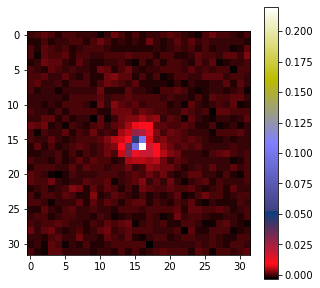

In [30]:
plt.figure(figsize=(5,5))
plt.imshow(dataset['noisy_stars'][18,:,:], cmap='gist_stern');plt.colorbar()
plt.show()